<a href="https://colab.research.google.com/github/kimsuazo/DeepLearningStuff/blob/master/CNN's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with a Convolutional Neural Network

**Notebook created in PyTorch by [Santi Pascual](https://github.com/santi-pdp) for the [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) (2019).**

Based on an original version in Keras created by [Miriam Bellver](https://imatge.upc.edu/web/people/miriam-bellver) for the [Barcelona Technology School](https://barcelonatechnologyschool.com/master/master-in-big-data-solutions/) (BTS) in 2018, and updated by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) and [Xavier Giro](https://imatge.upc.edu/web/people/xavier-giro) in 2019.

### Advice: Select the GPU Hardware Acceleration in the Runtime environment Menu to train the network fast.

We will start replicating the imports and Dataset from the last lab (where MLPs were used to classify MNIST images).

In [0]:
import numpy as np
np.random.seed(1)
import torch
import torch.optim as optim
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import default_timer as timer

### Defining the Hyper-parameters

We now define the hyperparameters that are going to be used throughout the notebook
to define the network, the data `batch_size`, the training `learning_rate`, and others.

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

# whenever we send something to the selected device (X.to(device)) we already use
# either CPU or CUDA (GPU). Importantly...
# The .to() operation is in-place for nn.Module's, so network.to(device) suffices
# The .to() operation is NOT in.place for tensors, so we must assign the result
# to some tensor, like: X = X.to(device)


In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20336492.50it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 299925.27it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 4977486.68it/s]                           
8192it [00:00, 125850.63it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = mnist_trainset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print('The Batched tensors return a collection of {} grayscale images ({} channel, {} height pixels, {} width pixels)'.format(bimg.shape[0],
                                                                                                                              bimg.shape[1],
                                                                                                                              bimg.shape[2],
                                                                                                                              bimg.shape[3]))
print('In the case of the labels, we obtain {} batched integers, one per image'.format(blabel.shape[0]))

Img shape:  torch.Size([1, 28, 28])
Label:  5
Batch Img shape:  torch.Size([64, 1, 28, 28])
Batch Label shape:  torch.Size([64])
The Batched tensors return a collection of 64 grayscale images (1 channel, 28 height pixels, 28 width pixels)
In the case of the labels, we obtain 64 batched integers, one per image


### About Convolutional Neural Networks

Previously, we trained a network using fully connected layers to classify images. However, in the lectures we learned that when dealing with images, Convolutional Neural Networks (CNNs) are more convenient because they deal better with local correlations in the data (as with images). So now we are going to train a CNN for multiclass classification.

The following lines show what a basic convnet looks like. It's a stack of Conv2D and MaxPooling2D layers.  





In [0]:
# Let's first define a 2D convolutional layer with 1 input channel, 3 output channels and (height=3, width=3) kernel size

conv = nn.Conv2d(1, 3, 3)

Importantly, a convnet takes input tensors of shape `(batch, num_channels, image_height, image_width)`. In our case, we will configure our convnet to process inputs of size `(1, H, W)`, which is the format of MNIST images. 
Let's try with some random image.


In [0]:
x = torch.rand(1, 1, 28, 28)
y = conv(x)
print('Output shape: {} = conv({})'.format(y.shape, x.shape))

Output shape: torch.Size([1, 3, 26, 26]) = conv(torch.Size([1, 1, 28, 28]))


>> Alice: Note that the only actual number we specify from the input data is the number of channels! No image dimensions are given to the convolutional layer. These are just used to shape the data `x`.

>> Bob: Why is that?

>> <p>Alice: Because of PyTorch magic &#128526;</p>

>> <p>Bob: No, seriously. Why? &#128565;</p>

>> Alice: Because of the dynamic computational graph (DCG)!

**Do you remember all that stuff about a certain dynamic computational graph? Well here it goes in action. Do we need to specify a fixed size for the images as in other frameworks (such as Keras, TensorFlow, etc.) ? Nope. Because we can forward any image size at any time through the same convolutional layer!**

As another example. Let's forward an image of size (11, 11).

In [0]:
x = torch.rand(1, 1, 11, 11)
y = conv(x)
print('Output shape: {} = conv({})'.format(y.shape, x.shape))

Output shape: torch.Size([1, 3, 9, 9]) = conv(torch.Size([1, 1, 11, 11]))


**Tadáaaa**, it did accept the input data, and give a corresponding output shape. **The only argument related to the data required in the convolutional definition is the number of channels.**

### Exercise 1

Why do the output spatial dimensions (`dim=2` and `dim=3`) differ from the input ones? Re-define the `conv` layer below setting the appropriate property such that the output spatial shape is the same as the input one. Look at the PyTorch documentation (`https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d`) for more reference.

In [0]:
# TO DO: define the conv layer below and ensure that the output tensor shape in dimensions {H, W} 
#( as in [1, channels, H, W] ) will be the same as the input in both cases.
conv=nn.Conv2d(1,3,3, padding = 1)

x = torch.rand(1, 1, 20, 20)
y = conv(x)
print('Output shape: {} = conv({})'.format(y.shape, x.shape))
assert y.shape[2:] == x.shape[2:], 'Err: conv not well specified!'
x = torch.rand(1, 1, 11, 11)
y = conv(x)
print('Output shape: {} = conv({})'.format(y.shape, x.shape))
assert y.shape[2:] == x.shape[2:], 'Err: conv not well specified!'

Output shape: torch.Size([1, 3, 20, 20]) = conv(torch.Size([1, 1, 20, 20]))
Output shape: torch.Size([1, 3, 11, 11]) = conv(torch.Size([1, 1, 11, 11]))


### About Pooling

Pooling refers to a block where downsampling happens. In the case of CNNs, as they process full images throughout a certain stack of layers that can get quite deep, they occupy a lot of memory to store the so called feature maps. Feature maps are the intermediate hidden activations of a CNN. The next image ([from a Quora response](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks)) is very self-explainatory of what **Max Pooling** does applied to images and spatial feature maps.

![](https://qph.fs.quoracdn.net/main-qimg-40cdeb3b43594f4b1b1b6e2c137e80b7)

As you see, it decimates neighboring regions by picking the max value within that region. And that happens for every channel in the feature map (or the image, if it is grayscale/RGB).

The are also other pooling methods, like [`AvgPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.AvgPool2d), strided Convolutions (simply incrasing the `stride > 1` of the `torch.nn.Conv2d` layer, etc. Each one has its advantages and drawbacks, which are so far out of the scope of this study on how to define a CNN in PyTorch.

In any case, a good question for now is: **what are the advantages of using pooling of any kind?**

Let's define a small CNN without pooling and another one with pooling, and let's check the amount of memory used by each in terms of feature map usage and the time it takes to forward an image of `512x512` pixels with just `1` input channel (hence greyscale). 

In [0]:
NUM_BITS_FLOAT32 = 32

# Let's define a class that encapsulates a collection of layers we pass in
# for each forwarded layer, it retains the amount of consumed memory for
# the returned feature map. It also displays the total amount used after 
# all blocks are ran.
class CNNMemAnalyzer(nn.Module):

  def __init__(self, layers):
    super().__init__()
    self.layers = layers
  
  def forward(self, x):
    tot_mbytes = 0
    spat_res = []
    for layer in self.layers:
      h = layer(x)
      mem_h_bytes = np.cumprod(h.shape)[-1] * NUM_BITS_FLOAT32 // 8
      mem_h_mb = mem_h_bytes / 1e6
      print('-' * 30)
      print('New feature map of shape: ', h.shape)
      print('Mem usage: {} MB'.format(mem_h_mb))
      x = h
      if isinstance(layer, nn.Conv2d):
        # keep track of the current spatial width for conv layers
        spat_res.append(h.shape[-1])
      tot_mbytes += mem_h_mb
    print('=' * 30)
    print('Total used memory: {:.2f} MB'.format(tot_mbytes))
    return tot_mbytes, spat_res

#### Forwarding the 512x512 image through a non-pooled CNN

In [0]:
# First, make a plain stack of convlayers
cnn = CNNMemAnalyzer(nn.ModuleList([nn.Conv2d(1, 32, 3),
                                    nn.Conv2d(32, 64, 3),
                                    nn.Conv2d(64, 64, 3),
                                    nn.Conv2d(64, 128, 3),
                                    nn.Conv2d(128, 512, 3)]))

# Let's work with a realistic 512x512 image size
# Also, keep track of time to make forward
beg_t = timer()
nopool_mbytes, nopool_res = cnn(torch.randn(1, 1, 512, 512))
end_t = timer()
nopool_time = end_t - beg_t
print('Total inference time for non-pooled CNN: {:.2f} s'.format(nopool_time))

------------------------------
New feature map of shape:  torch.Size([1, 32, 510, 510])
Mem usage: 33.2928 MB
------------------------------
New feature map of shape:  torch.Size([1, 64, 508, 508])
Mem usage: 66.064384 MB
------------------------------
New feature map of shape:  torch.Size([1, 64, 506, 506])
Mem usage: 65.545216 MB
------------------------------
New feature map of shape:  torch.Size([1, 128, 504, 504])
Mem usage: 130.056192 MB
------------------------------
New feature map of shape:  torch.Size([1, 512, 502, 502])
Mem usage: 516.104192 MB
Total used memory: 811.06 MB
Total inference time for non-pooled CNN: 6.03 s


#### Forwarding the 512x512 image through a pooled CNN

In [0]:
# Now, let's make a stack of convlayers combined with MaxPoolings
cnn = CNNMemAnalyzer(nn.ModuleList([nn.Conv2d(1, 32, 3),
                                    nn.MaxPool2d(2),
                                    nn.Conv2d(32, 64, 3),
                                    nn.MaxPool2d(2),
                                    nn.Conv2d(64, 64, 3),
                                    nn.Conv2d(64, 128, 3),
                                    nn.Conv2d(128, 512, 3)]))

beg_t = timer()
pool_mbytes, pool_res = cnn(torch.randn(1, 1, 512, 512))
end_t = timer()
pool_time = end_t - beg_t
print('Total inference time for pooled CNN: {:.2f} s'.format(pool_time))

------------------------------
New feature map of shape:  torch.Size([1, 32, 510, 510])
Mem usage: 33.2928 MB
------------------------------
New feature map of shape:  torch.Size([1, 32, 255, 255])
Mem usage: 8.3232 MB
------------------------------
New feature map of shape:  torch.Size([1, 64, 253, 253])
Mem usage: 16.386304 MB
------------------------------
New feature map of shape:  torch.Size([1, 64, 126, 126])
Mem usage: 4.064256 MB
------------------------------
New feature map of shape:  torch.Size([1, 64, 124, 124])
Mem usage: 3.936256 MB
------------------------------
New feature map of shape:  torch.Size([1, 128, 122, 122])
Mem usage: 7.620608 MB
------------------------------
New feature map of shape:  torch.Size([1, 512, 120, 120])
Mem usage: 29.4912 MB
Total used memory: 103.11 MB
Total inference time for pooled CNN: 0.49 s


In [0]:
mem_ratio = 1. - pool_mbytes / nopool_mbytes
print('Total saved memory with poolings: ', 100. * mem_ratio)

time_ratio = nopool_time / pool_time
print('Total inference speed increase with poolings: x{:.1f}'.format(time_ratio))

Total saved memory with poolings:  87.28648064808753
Total inference speed increase with poolings: x12.3


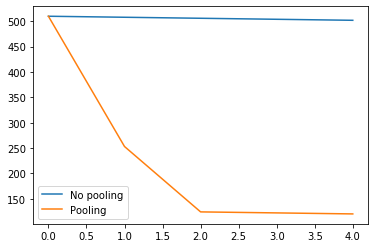

In [0]:
# Let's plot the width of each feature map as we get deeper into the network
_ = plt.plot(nopool_res, label='No pooling')
_ = plt.plot(pool_res, label='Pooling')
_ = plt.legend()

### Key Observations

* We save 87.3% of memory having a model which is pooling after the first couple of conv layers. 
* The model that contains pooling runs 11.1 times faster in inference than the other one.
* The width dimension decreases exponentially when inserting the poolings, compared to the one without those poolings.

The convolutional operator works by sweeping the kernel filters through the input image. If we pool `x2` in a couple layers, from the 3rd convlayer onwards we have a `x4` smaller spatial resolution. This means it has to run through by far less pixels to process the whole feature map in those layers. Also, each feature occupies much less memory for the reduced resolution. Pooling is hence a practical downsampling to make our nets fit in memory, and also to get the salient features from the previous incoming feature maps (it gets the maximum activation and forwards only that one within a window). In general, for classification, it is usual to have pooling to condense spatial dimensions into less-and-more-abstract ones. This is done by finish processing the last reduced spatial feature map with some fully connected layer that mixes it all up.

## Grand Finale: Building a (pseudo) LeNet model

Here we will gather the puzzle pieces we have so far (tensor manipulations, convs, poolings, fully connected layers, etc.) and we will define a pseudo-LeNet model ([LeNet ref](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)). We say "pseudo" because we will obviate the type of actual pooling that the authors proposed by then, or the gaussian connections, or the `Tanh` activations. We will instead use `MaxPooling`s, `Fully connected` layers all the way through, and `ReLU` activations.

For reference, the LeNet model is the following:
![](https://miro.medium.com/max/2154/1*1TI1aGBZ4dybR6__DI9dzA.png)

### Exercise 2

Make the `ConvBlock` class to properly do: `Conv2d`, `ReLU`, and `MaxPool2d`. Ensure that for an input of size `1x32x32` you obtain an output feature map of size `6x14x14` as shown in the figure above for layer `S2`.

In [0]:
class ConvBlock(nn.Module):

  def __init__(self, num_inp_channels, num_out_fmaps, 
               kernel_size, pool_size=2):
    super().__init__()
    # TODO: define the 3 modules needed
    self.conv = nn.Conv2d(num_inp_channels, num_out_fmaps, kernel_size)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(pool_size)
  
  def forward(self, x):
    return self.maxpool(self.relu(self.conv(x)))

x = torch.randn(1, 1, 32, 32)
y = ConvBlock(1, 6, 5, 4)(x)
assert y.shape[1] == 6, 'The amount of feature maps is not correct!'
#assert y.shape[2] == 14 and y.shape[3] == 14, 'The spatial dimensions are not correct!'
print('Input shape: {}'.format(x.shape))
print('ConvBlock output shape (S2 level in Figure): {}'.format(y.shape))

Input shape: torch.Size([1, 1, 32, 32])
ConvBlock output shape (S2 level in Figure): torch.Size([1, 6, 7, 7])


### Exercise 3

Finish the `PseudoLeNet` class by including the following: 
1. As the input images from MNIST are 28x28, add padding to make them 32x32 with the `torch.nn.ConstantPad2d` (https://pytorch.org/docs/stable/nn.html#torch.nn.ConstantPad2d).
2. Build the `mlp` classifier as a `nn.Sequential` stack of fully connected layers and ReLU activations, with the sizes shown in the figure above: [120, 84, 10]. Plug the appropriate output activation in the end to do multi-class classification.
3. Remember to "flatten" the feature maps coming out of the second `ConvBlock` and connect them to the output `mlp` to build the classifier in the `forward` function. This has to be done because fully connected layers (`Linear`) only accept features without any spatial dimension. Hence, all these spatial dimensions and channels are unrolled into single vectors, one per batch sample. **HINT: Remember the `.view()` operator to change tensors shape!**

In [0]:
class PseudoLeNet(nn.Module):

  def __init__(self):
    super().__init__()
    # TODO: Define the padding
    self.pad = nn.ConstantPad2d(2, 0)
    self.conv1 = ConvBlock(1, 6, 5)
    self.conv2 = ConvBlock(6, 16, 5)
    # TODO: Define the MLP at the deepest layers
    self.mlp = nn.Sequential(
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
        nn.LogSoftmax()
    )

  def forward(self, x):
    x = self.pad(x)
    x = self.conv1(x)
    x = self.conv2(x)
    # Obtain the parameters of the tensor in terms of:
    # 1) batch size
    # 2) number of channels
    # 3) spatial "height"
    # 4) spatial "width"
    bsz, nch, height, width = x.shape
    # TODO: Flatten the feature map with the view() operator 
    # within each batch sample    
    x = x.view(bsz, nch * height * width)
    y = self.mlp(x)
    return y

# Let's forward a toy example emulating the MNIST image size
plenet = PseudoLeNet()
y = plenet(torch.randn(1, 1, 28, 28))
print(y.shape)

torch.Size([1, 10])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Now it's time to train and test the model. 

We take the previous training and test codes from MLP lab models and run them straightaway. Execute the cells below without more hessitation.

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [0]:
tr_losses = []
te_losses = []
te_accs = []
network = PseudoLeNet()
network.to(hparams['device'])
optimizer = optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(1, hparams['num_epochs'] + 1):
  tr_losses.append(train_epoch(train_loader, network, optimizer, criterion, hparams))
  te_loss, te_acc = test_epoch(test_loader, network, hparams)
  te_losses.append(te_loss)
  te_accs.append(te_acc)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324406
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.128023
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.105216
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.040545
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.171201
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.090188
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.078275
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.050390
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.026995
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.016613

Test set: Average loss: 0.0511, Accuracy: 9845/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.008128
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.042735
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.008388
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.076429
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.077455
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.031273
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.079136
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.084739
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.041527
T

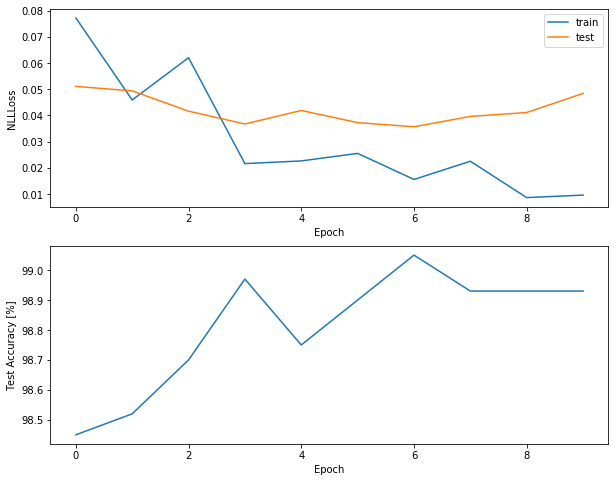

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(tr_losses, label='train')
plt.plot(te_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(te_accs)

### The final result should be slightly above 99%, better than the MLP model for a comparable amount of training.